<a href="https://colab.research.google.com/github/BenGardiner18/Fran-ois-Chollet-Deep-Learning-with-Python/blob/main/ch10_temp_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading and unzipping the data

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-10 22:21:34--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.23MB/s    in 2.5s    

2022-11-10 22:21:38 (5.23 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
from tensorflow import keras

In [3]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f: data = f.read()
lines = data.split("\n") 
header = lines[0].split(",") 
lines = lines[1:] 
print(header) # prints the names of the columns 
print(len(lines)) # prints the number of records of data 


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Transferring data from csv file to numpy arrays. The temperature array is our y or target and the other attributes like pressure become our training data or x. We're dropping the time column.

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]] 
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

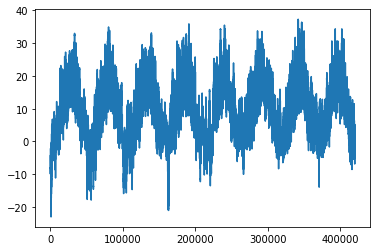

In [5]:
from matplotlib import pyplot as plt 
plt.plot(range(len(temperature)), temperature)

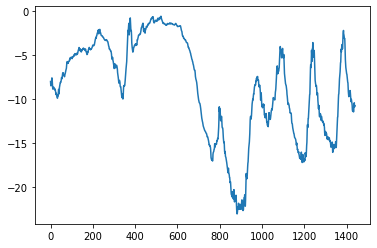

In [6]:
plt.plot(range(1440), temperature[:1440])

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Since the data for each column has a different scale, we must normalize the data before sending it to the model.

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Creating datasets for train, val, and test

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# train
train_dataset = keras.utils.timeseries_dataset_from_array( 
    raw_data[:-delay],
    targets=temperature[delay:], 
    sampling_rate=sampling_rate, 
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# val
val_dataset = keras.utils.timeseries_dataset_from_array( 
    raw_data[:-delay],
    targets=temperature[delay:], 
    sampling_rate=sampling_rate, 
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# test
test_dataset = keras.utils.timeseries_dataset_from_array( 
    raw_data[:-delay],
    targets=temperature[delay:], 
    sampling_rate=sampling_rate, 
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size, 
    start_index=num_train_samples + num_val_samples)

Developing a very basic common sense model to predict the weather. This will act as our baseline to try to beat. This model simply looks at yesterday's temeprature and assumes it'll be the same as todays.

In [10]:
def evaluate_naive_method(dataset): 
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
          preds = samples[:, -1, 1] * std[1] + mean[1]
          total_abs_err += np.sum(np.abs(preds - targets))
          samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


# Dense Layers

In [11]:
from tensorflow.keras import layers


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 52ms/step - loss: 14.6535 - mae: 2.9371 - val_loss: 11.9499 - val_mae: 2.7419
Epoch 2/10
819/819 [==============================] - 37s 45ms/step - loss: 9.3829 - mae: 2.4107 - val_loss: 10.0420 - val_mae: 2.5098
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 8.6074 - mae: 2.3150 - val_loss: 10.5678 - val_mae: 2.5830
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 8.1475 - mae: 2.2567 - val_loss: 11.3937 - val_mae: 2.6816
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 7.8323 - mae: 2.2128 - val_loss: 10.5697 - val_mae: 2.5866
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 7.5679 - mae: 2.1744 - val_loss: 11.0109 - val_mae: 2.6348
Epoch 7/10
819/819 [==============================] - 37s 45ms/step - loss: 7.3829 - mae: 2.1508 - val_loss: 13.1118 - val_mae: 2.8846
Epoch 8/10
819/819 [==============================] - 

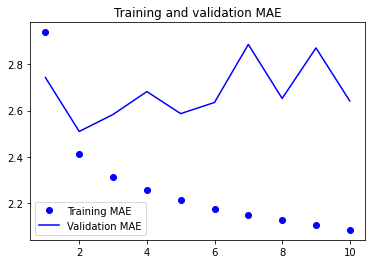

In [12]:
import matplotlib.pyplot as plt

loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 1D Covnets 

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 57ms/step - loss: 22.6526 - mae: 3.7416 - val_loss: 16.1843 - val_mae: 3.1794
Epoch 2/10
819/819 [==============================] - 39s 48ms/step - loss: 15.4528 - mae: 3.1276 - val_loss: 14.1922 - val_mae: 2.9852
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 14.1654 - mae: 2.9864 - val_loss: 15.6962 - val_mae: 3.1413
Epoch 4/10
819/819 [==============================] - 39s 48ms/step - loss: 13.4841 - mae: 2.9107 - val_loss: 14.5418 - val_mae: 3.0147
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 12.9644 - mae: 2.8518 - val_loss: 14.3991 - val_mae: 2.9898
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 12.5594 - mae: 2.8046 - val_loss: 14.5720 - val_mae: 3.0056
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 12.2013 - mae: 2.7630 - val_loss: 14.9758 - val_mae: 3.0665
Epoch 8/10
819/819 [============================

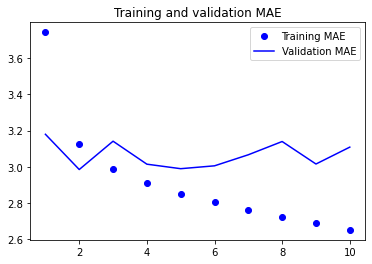

In [14]:
loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# LSTM Layers

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_lstm.keras",
        save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 51ms/step - loss: 44.6624 - mae: 4.8893 - val_loss: 14.0182 - val_mae: 2.8169
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 11.0565 - mae: 2.5759 - val_loss: 9.3659 - val_mae: 2.3812
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.7688 - mae: 2.4307 - val_loss: 9.5609 - val_mae: 2.4016
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 9.3692 - mae: 2.3781 - val_loss: 9.3851 - val_mae: 2.3790
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.0882 - mae: 2.3422 - val_loss: 9.2707 - val_mae: 2.3700
Epoch 6/10
819/819 [==============================] - 42s 52ms/step - loss: 8.7878 - mae: 2.3044 - val_loss: 9.2757 - val_mae: 2.3756
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.5802 - mae: 2.2769 - val_loss: 9.4853 - val_mae: 2.3929
Epoch 8/10
819/819 [==============================] - 43s 5

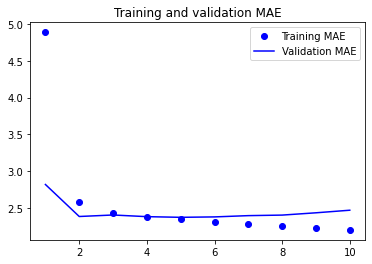

In [16]:
loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

This model narrowly beats the baseline!

# Simple RNN Layer

In [19]:
num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs) 
x = layers.SimpleRNN(16, return_sequences=True)(x) 
outputs = layers.SimpleRNN(16)(x)
outputs.shape

TensorShape([None, 16])